# OONI Data Analysis

In [2]:
# Basic Imports
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

# Plotting Imports
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn
from sklearn import metrics

# Statstools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Plot configuration
sns.set_style('darkgrid')
sns.set_palette('tab10')
palette = sns.color_palette()

In [13]:
# Data paths
base_dir = '../results/'
hr_dir = os.path.join(base_dir, 'HR', 'processed')
hr_years = ['2022', '2023']
np_dir = os.path.join(base_dir, 'NP', 'processed')
np_years = ['2022']
by_dir = os.path.join(base_dir, 'BY', 'processed')
by_years = ['2022']

## 1 Introduction

(INTRODUCTION)

### 1.1 Dataset

*You must provide background on the dataset or datasets you
worked with, such as who created it, why, how it was collected, for what purpose
it was collected, what attributes are included, what representation decisions
were made and how that affects the data, etc. A good reference for questions
to ask about your data is the paper “Datasheets for Datasets,” by Gebru et al.
(2018) (https://arxiv.org/abs/1803.09010).*

Our dataset was created by the Open Observatory of Network Interference (OONI), a non-profit organization based in Italy focused on fighting internet censorship worldwide. The project was originally founded by The Tor Project, but now most of its funding comes from donations.

The dataset comes from the OONI Probe, a mobile app launched by OONI in 2017. At the time, it collected the largest dataset on internet censorship ever recorded. To this day, it remains the largest publicly available dataset on the topic. The app runs in the background on any phone that has it installed. OONI organizes coordinated tests, where phones in a specific region perform tests at the same time. These phones send internet requests to various sources, and the responses are reported back to a server at OONI’s headquarters. This process provides a broad overview of internet connectivity in regions with OONI app users. Researchers can analyze the data to identify sites and services that are consistently blocked, or use models to detect significant changes in internet access.

When sites are temporarily blocked, often due to political reasons, this is referred to as "temporal blocking." We chose this dataset to analyze after reading a paper (https://www.ndss-symposium.org/ndss-paper/modeling-and-detecting-internet-censorship-events/) that identified instances of temporal blocking in Nepal in 2022. Temporal blocking is a major challenge facing the free world. Smaller, and less indistrialized nations often get away with temporal blocking of political content around elections. Our goal for this project revolves around characterizing temporal censorship events.

The OONI probe performs at least 17 different types of tests. We won't go over all of them here, but we decided to focus on the web connectivity tests due to the large amount of data, and ease of interpretation. These tests first send out a DNS request for the targeted domain, and report if the DNS request returned as expected. If so, they then send out an HTTPS request to the domain, and record the response. This gives a broad view of whether citizens in a specific region are able to access content that OONI deems important or controversial. A control connection is also sent out at the same time called a "test helper". The responses of the test helper, and the tests are compared to create the final data point.

The web connectivity tests are massive. The entire OONI database is several terabytes of data. We decided to focus on specific regions during the same timeframe to perform our analysis. Due to the paper that we read, we started with Nepal 2022. We decided to analyze two other countries during the same timeframe, to use as points of comparison: Croatia and Belarus. We were looking for other small countries, and we wanted two countries on opposite sides of the censorship spectrum. Belarus is a well known censored country, and Croatia's constitution bans any form of internet censorship, thus they seemed like a perfect choice. Due to some issues with the dataset that we will discuss later, we ended up pivoting to focus on Croatia, and thus downloaded the Croatia 2021 and 2023 datasets as well to supplement our study.

In [23]:
# Load all datasets
web_data = {
    'hr' : {
        year : pd.read_csv(os.path.join(hr_dir, year, 'webconnectivity.csv')) for year in hr_years
    },
    'np' : {
        year : pd.read_csv(os.path.join(np_dir, year, 'webconnectivity.csv')) for year in np_years
    },
    'by' : {
        year : pd.read_csv(os.path.join(by_dir, year, 'webconnectivity.csv')) for year in by_years
    }
}

# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path

# Loop through all datasets and clean
for country in web_data:
    for year in web_data[country]:
        wd = web_data[country][year]
        wd['date'] = pd.to_datetime(wd['date'])
        wd = wd.set_index('date')
        wd['input'] = wd['input'].map(url_standardize)
        web_data[country][year] = wd

The structure of the data is as follows. There are 18 different fields in the dataset:

- Date - when the test occured
- Probe_asn - what network the test occured in, using the unique Autonomous System number
- Status_code_match - whether the HTTPS status code matches between the test and control
- Resolver_asn - what network the DNS resolver contacted is located in
- X_null_null_flags - unused
- Body_length_match - whether the length of the response body match between the test and control
- DNS_consistency - whether the DNS resolution is consistent between the test and control
- Headers_match - whether the final response headers match between the test and control
- DNS_experiment_failure - describes the specific failures of any DNS request
- HTTP_experiment_failure - describes the specific failures of any HTTP request
- Body_proportion - The ratio of body lengths between the control and test response
- Title_match - whether the final response title matches between the test and control
- Blocking - says whether the domain has been judged to be blocked or not by OONI's algorithm
- Accessible - whether or not the final response was able to reach the requested domain
- X_dns_flags - unused
- Control_failure - describes the specific failures of any control request
- X_blocking_flags - unused
- input - the domain the test wanted to connect to


In [24]:
# Show some example data
web_data['np']['2022']

,probe_asn,status_code_match,resolver_asn,x_null_null_flags,body_length_match,dns_consistency,headers_match,dns_experiment_failure,http_experiment_failure,body_proportion,title_match,blocking,accessible,x_dns_flags,control_failure,x_blocking_flags,input
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,fteproxy.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,sbc.net/
2022-01-02,AS17501,True,AS17501,NaN,True,inconsistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,ecequality.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,episcopalchurch.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,0.999723,True,False,True,NaN,NaN,NaN,icrw.org/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,True,AS23752,NaN,True,consistent,True,NaN,NaN,0.975015,NaN,False,True,NaN,NaN,NaN,facebook.com/
2022-12-31,AS23752,False,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,instagram.com/
2022-12-31,AS23752,True,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,youtube.com/


Of these fields, we care about 3 of them for our analysis: date, input, and blocking. Luckily for us, the blocking field already does all of the preprocessing we would need to detect blocking events. This field analyzes each of the other fields to tell us whether or not blocking has occurred, and what type of blocking the heuristics believe has occurred. The possible values are as follows:

In [35]:
# Show unique test types
pd.Series(web_data['hr']['2022']['blocking'].sort_values().unique())

0           False
1             dns
2       http-diff
3    http-failure
4          tcp_ip
5             NaN
dtype: object

These specific blocking test responses are:
* `False` - No blocking methods were detected
  * Either the site is accessible, or the site is inaccesible to both the test and control groups.
* `NaN` - The results of the test were inconclusive, and thus should be discarded
  * We ignore these in our visualization, and model creation.
* `dns` - The DNS server does not resolve the site properly
  * This is a common method of censorship. Detected by comparing the test and control DNS responses. Returns if the test gets a DNS error that the control doesn't, or if the test and control resolve to different IP addresses. Both are signs of network errors, or censorship
* `httpdiff` - The HTTP response differs between test and control.
  * Some groups implement censorship using firewalls with distinct blockpages. This is detected by analyzing the body_length_match, headers_match, and title_match. If the body_length does not match, but the body proportion is below a threshold, it does not flag for censorship.
* `httpfail` - The HTTP response returns with a failure error code, while the control does not
  * Many groups do censorship using deep packet inspection to see the content of your sent message. If the content is in some way objectionable to them, they return a 404 error or something similar to censor your request.
* `tcp` - The response returned with the TCP RST flag set to 1
  * This flag is normally used when a machine needs to suddenly halt communication for any reason. Groups implement IP address blocking by viewing the IP address of the destination, and stopping the packet. They then send back a packet with the TCP RST flag set to 1. This kills the TCP session, and displays the message "This site can't be reached" to the user.


In [36]:
# Filter data into specific blocking methods
event_types = pd.Series(web_data['hr']['2022']['blocking'].dropna().sort_values().unique())
blocking_events = {
    country : {
        year : {
            event_type: web_data[country][year][web_data[country][year]['blocking'] == event_type]
            for event_type in event_types
        } for year in web_data[country]
    } for country in web_data
}

In [27]:
# Compute rolling totals
k=7
totals = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals[country][year][event_type] = tmp.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

In [28]:
# Calculate fractional events
fracs = {country : { year : {} for year in totals[country] } for country in totals}
for country in totals:
    for year in totals[country]:
        # Calculate fractional of all possible events
        d = pd.DataFrame(totals[country][year])
        tsum = d.sum(axis=1)
        fracs[country][year] =  d.div(tsum, axis=0).fillna(0)

Let's take a look at what types of events are occurring throughout time in various countries.

Text(0.5, 1.0, 'Fractional Blocking Events For Nepal in 2022 Over Time (k=7)')

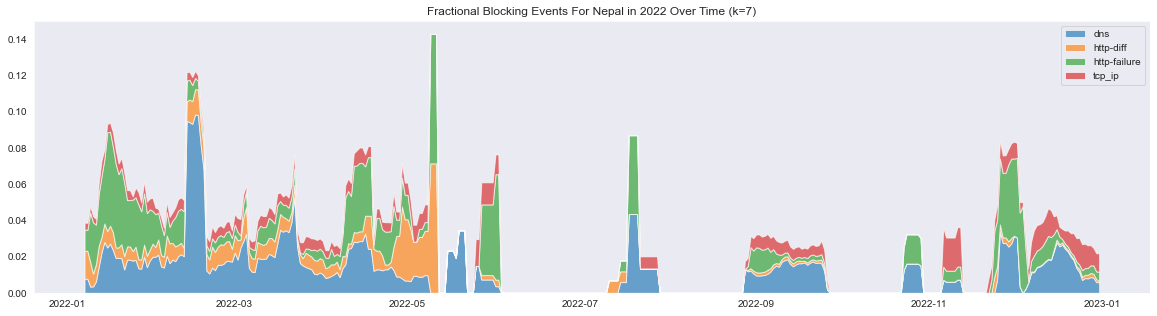

In [29]:
# Select a country and year
country = 'np'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Nepal in {year} Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events For Belarus in 2022 Over Time (k=7)')

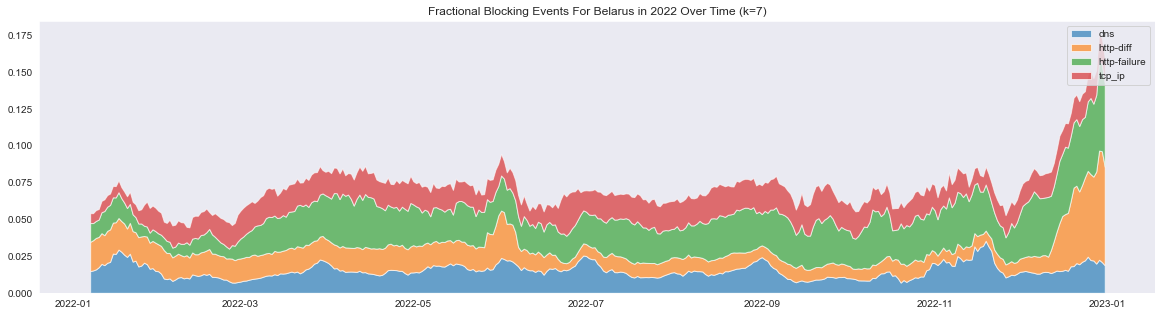

In [30]:
# Select a country and year
country = 'by'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Belarus in {year} Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events For Croatia in 2022 Over Time (k=7)')

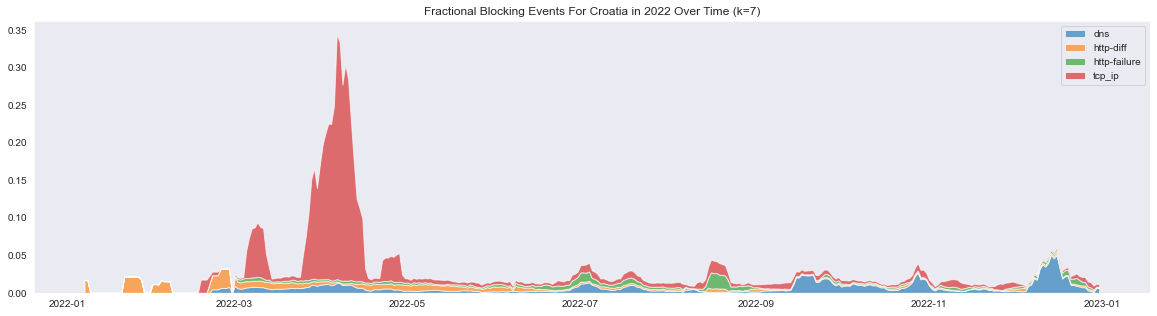

In [31]:
# Select a country and year
country = 'hr'
year = '2022'
f = fracs[country][year]
f = f[f.columns[f.columns != 'False']]
ft = [f[c] for c in f.columns.sort_values()]

# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Croatia in {year} Over Time (k={k})')

Looking at these three plots, 

----

## Questions

*You must clearly state the questions you’re attempting to answer.
Some questions could be a bit vague or broad, such as determining the basic
properties of the different attributes, but others should be more specific, such
as determining if a particular relationship exists.*

After some exploration however, we found that the OONI dataset did not contain the reported censorship event. The paper we read used a different dataset, known as Censored Planet. This group using remote measurements to analyze every large network on Earth. OONI is only able to analyze networks they have probe instances inside of. It appears that no OONI probe was in the affected networks in Nepal during the censorship event. The Censored Planet database costs a significant